In [6]:
from gelos.config import RAW_DATA_DIR, PROJ_ROOT, PROCESSED_DATA_DIR, DATA_VERSION, REPORTS_DIR, FIGURES_DIR
import geopandas as gpd
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict, Counter
import yaml
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
yaml_name = "prithvieov2300_noperturb.yaml"

In [4]:

output_dir = PROCESSED_DATA_DIR / DATA_VERSION
data_root = RAW_DATA_DIR / DATA_VERSION
chip_gdf = gpd.read_file(output_dir / 'gelos_chip_tracker_with_tsne.geojson')
reports_dir = REPORTS_DIR / DATA_VERSION
reports_dir.mkdir(exist_ok=True, parents=True)
figures_dir = FIGURES_DIR / DATA_VERSION
figures_dir.mkdir(exist_ok=True, parents=True)

yaml_config_directory = PROJ_ROOT / 'gelos' / 'configs'
yaml_filepath = yaml_config_directory / yaml_name
with open(yaml_filepath, "r") as f:
    yaml_config = yaml.safe_load(f)
print(yaml.dump(yaml_config))
model_name = yaml_config['model']['init_args']['model']
model_title = yaml_config['model']['title']
embedding_extraction_strategies = yaml_config['embedding_extraction_strategies']

# add variables to yaml config so it can be passed to classes
yaml_config['data']['init_args']['data_root'] = data_root
yaml_config['model']['init_args']['output_dir'] = output_dir
embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]


data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:
      - BLUE
      - GREEN
      - RED
      - NIR

In [7]:

for embeddings_directory in embeddings_directories:

    embedding_layer = embeddings_directory.stem

    for extraction_strategy, slice_args in embedding_extraction_strategies.items():
        print(extraction_strategy, model_title)
        break


CLS Token Prithvi EO V2 300M
CLS Token Prithvi EO V2 300M
CLS Token Prithvi EO V2 300M


In [8]:

model_title_lower = model_title.replace(" ", "").lower()
extraction_strategy_lower = extraction_strategy.replace(" ", "").lower()
emebdding_layer_lower = embedding_layer.replace("_","").lower()

In [11]:
embedding_csv_paths = output_dir.glob(f"*{model_title_lower}_{extraction_strategy_lower}*")
for embedding_csv_path in embedding_csv_paths:
    embed_df = gpd.read_file(embedding_csv_path).drop("id", axis=1)
    chip_gdf = chip_gdf.merge(embed_df, left_index=True, right_index=True, how="left")

MergeError: Passing 'suffixes' which cause duplicate columns {'prithvieov2300m_clstoken_tsne_x_x', 'prithvieov2300m_clstoken_tsne_y_x'} is not allowed.

In [12]:
X = chip_gdf[[
    f"{model_title_lower}_{extraction_strategy_lower}_tsne_x",
    f"{model_title_lower}_{extraction_strategy_lower}_tsne_y"
    ]]
y = chip_gdf["category"]

In [13]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_fold_metrics = []
chip_error_counts = pd.Series(0, index=chip_gdf.index, dtype=float)
chip_eval_counts = pd.Series(0, index=chip_gdf.index, dtype=int)
chip_mislabel_counts = defaultdict(Counter)
cv_true_labels = []
cv_pred_labels = []

for fold_idx, (train_idx, test_idx) in enumerate(
    tqdm(rskf.split(X, y), total=rskf.get_n_splits(X, y), desc="Cross-validation folds"),
    start=1
):
    cv_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_classifier.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_true_fold = y.iloc[test_idx]
    y_pred_fold = cv_classifier.predict(X.iloc[test_idx])
    fold_accuracy = accuracy_score(y_true_fold, y_pred_fold)
    cv_fold_metrics.append({"fold": fold_idx, "accuracy": fold_accuracy})
    cv_true_labels.extend(y_true_fold.tolist())
    cv_pred_labels.extend(y_pred_fold.tolist())
    chip_error_counts.iloc[test_idx] += (y_pred_fold != y_true_fold).astype(int)
    chip_eval_counts.iloc[test_idx] += 1
    mis_mask = (y_pred_fold != y_true_fold.to_numpy())
    mis_indices = y_true_fold.index[mis_mask]
    for chip_idx_val, mis_label in zip(mis_indices, y_pred_fold[mis_mask]):
        chip_mislabel_counts[chip_idx_val][mis_label] += 1

chip_gdf["cv_eval_count"] = chip_eval_counts
chip_gdf["cv_error_rate"] = (chip_error_counts / chip_eval_counts).fillna(0)
chip_gdf["cv_is_hard"] = chip_gdf["cv_error_rate"] >= 0.5
cv_metrics_df = pd.DataFrame(cv_fold_metrics)
top_mislabel = []
top_mislabel_count = []
for idx in chip_gdf.index:
    counter = chip_mislabel_counts.get(idx)
    if counter:
        label, count = counter.most_common(1)[0]
    else:
        label, count = (None, 0)
    top_mislabel.append(label)
    top_mislabel_count.append(count)
chip_gdf["cv_top_mislabel"] = top_mislabel
chip_gdf["cv_top_mislabel_count"] = top_mislabel_count

Cross-validation folds: 100%|██████████| 15/15 [01:09<00:00,  4.60s/it]


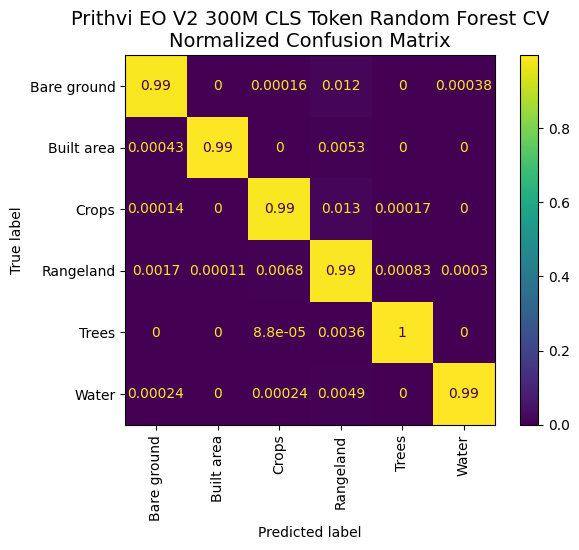

In [32]:
cv_label_order = sorted(y.unique())
cv_conf_matrix = confusion_matrix(
    cv_true_labels,
    cv_pred_labels,
    labels=cv_label_order,
    normalize="true"
)
cv_disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf_matrix, display_labels=cv_label_order)
cv_disp.plot(xticks_rotation="vertical", cmap="viridis")
cv_disp.ax_.set_title(
    f"{model_title} {extraction_strategy} Random Forest CV\nNormalized Confusion Matrix",
    fontsize=14
)
plt.savefig(
    figures_dir / f"{model_title_lower}_{extraction_strategy_lower}_{emebdding_layer_lower}_randomforestconfusionmatrix.png",
    bbox_inches="tight",
    pad_inches=0.2,
    dpi=300
)


In [15]:
print(
    f"Cross-validated accuracy (mean ± std): {cv_metrics_df['accuracy'].mean():.3f} ± {cv_metrics_df['accuracy'].std():.3f}"
)
display(cv_metrics_df)
hardest_chips = chip_gdf.sort_values("cv_error_rate", ascending=False).head(10)[[
    "category",
    "cv_error_rate",
    "cv_eval_count",
    "cv_is_hard",
    "cv_top_mislabel",
    "cv_top_mislabel_count"
]]
hardest_chips

Cross-validated accuracy (mean ± std): 0.990 ± 0.001


,fold,accuracy
0,1,0.990745
1,2,0.989919
2,3,0.990249
3,4,0.990249
4,5,0.991488
5,6,0.990332
6,7,0.989588
7,8,0.991158
8,9,0.989505
9,10,0.991075


,category,cv_error_rate,cv_eval_count,cv_is_hard,cv_top_mislabel,cv_top_mislabel_count
23072,Bare ground,1.0,3,True,Rangeland,3
398,Rangeland,1.0,3,True,Crops,3
18934,Crops,1.0,3,True,Rangeland,3
12493,Crops,1.0,3,True,Rangeland,3
12486,Rangeland,1.0,3,True,Crops,3
53895,Crops,1.0,3,True,Rangeland,3
31696,Rangeland,1.0,3,True,Crops,3
1632,Rangeland,1.0,3,True,Crops,3
12475,Bare ground,1.0,3,True,Rangeland,3
44904,Crops,1.0,3,True,Rangeland,3


In [16]:
from pathlib import Path

In [37]:
def construct_thumbnail_paths(row, data_root: Path):
    date_list = row[f"sentinel_2_dates"].split(",")
    id = row["id"]
    path_list = [data_root / f"sentinel_2_{id:06}_{date}.png" for date in date_list]
    return path_list

chip_gdf[f"sentinel_2_thumbnail_paths"] = chip_gdf.apply(
    construct_thumbnail_paths, data_root=data_root, axis=1
)

    


In [33]:
timestep_ranges = [
    "Jan-Mar",
    "Apr-Jun",
    "Jul-Sep",
    "Oct-Dec",
]

In [34]:
from gelos.plotting import format_lat_lon

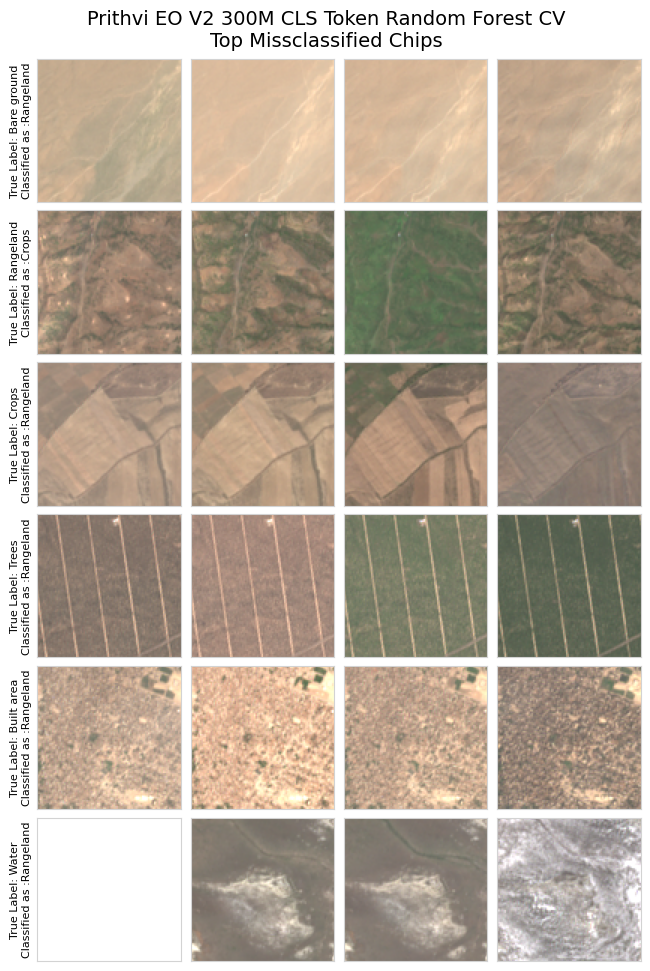

In [ ]:
hardest_by_class = (
    chip_gdf.dropna(subset=["cv_error_rate", "sentinel_2_thumbnail_paths"])
    .sort_values("cv_error_rate", ascending=False)
    .groupby("category")
    .head(1)
)

if hardest_by_class.empty:
    raise ValueError("No chips with thumbnails and cross-validation scores were found.")
ncols=4
fig, axes = plt.subplots(
    nrows=len(hardest_by_class),
    ncols=ncols,
    figsize=(ncols * 1.6, len(hardest_by_class) * 1.6),
    constrained_layout = True
)
axes = np.atleast_2d(axes)

for row_idx, (chip_idx, chip_row) in enumerate(hardest_by_class.iterrows()):
    thumbs = chip_row["sentinel_2_thumbnail_paths"]
    error_rate = chip_row["cv_error_rate"]
    mis_label = chip_row.get("cv_top_mislabel") or "–"
    mis_label_count = chip_row.get("cv_top_mislabel_count", 0)
    example_lat = chip_row.get("lat")
    example_lon = chip_row.get("lon")
    for col_idx in range(4):
        ax = axes[row_idx, col_idx]
        img = Image.open(thumbs[col_idx])
        ax.imshow(img)
        ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
        for spine in ax.spines.values():
            spine.set_edgecolor("lightgray")
        if col_idx == 0: 
            ax.set_ylabel(
                f"True Label: {chip_row['category']}\nClassified as: {mis_label}",
                rotation=90,
                ha="center",
                va="bottom",
                fontsize=8
            )
            # ax.set_title(
            #     f"True Label: {chip_row['category']}\nClassified as :{mis_label}",
            #     fontsize=8
            # )
            # ax.set_ylabel(format_lat_lon(example_lat, example_lon), rotation=90, ha="center", va="bottom")

plt.suptitle(f"{model_title} {extraction_strategy} Random Forest CV\nTop Missclassified Chips", fontsize=14)
plt.savefig(
    figures_dir / f"{model_title_lower}_{extraction_strategy_lower}_{emebdding_layer_lower}_randomforestmisclassifications.png",
    dpi=300
)
